# Adpated from Hail documentation here:
### https://hail.is/docs/stable/tutorials/hail-overview.html

In [1]:
from hail import *
hc = HailContext(sc)

Running on Apache Spark version 2.0.2
SparkUI available at http://10.240.0.30:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-5c275cc


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

In [3]:
# optional
import seaborn

In [4]:
import os
if os.path.isdir('data/1kg.vds') and os.path.isfile('data/1kg_annotations.txt'):
    print('All files are present and accounted for!')
else:
    import sys
    sys.stderr.write('Downloading data (~50M) from Google Storage...\n')
    import urllib
    import tarfile
    urllib.urlretrieve('https://storage.googleapis.com/hail-1kg/tutorial_data.tar',
                       'tutorial_data.tar')
    sys.stderr.write('Download finished!\n')
    sys.stderr.write('Extracting...\n')
    tarfile.open('tutorial_data.tar').extractall()
    if not (os.path.isdir('data/1kg.vds') and os.path.isfile('data/1kg_annotations.txt')):
        raise RuntimeError('Something went wrong!')
    else:
        sys.stderr.write('Done!\n')

Download finished!
Extracting...
Done!


In [5]:
! /usr/lib/hadoop/bin/hadoop fs -mkdir /data
! /usr/lib/hadoop/bin/hadoop fs -put /home/jupyter-user/data/* /data/

18/06/18 18:33:27 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.6-hadoop2
18/06/18 18:33:29 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: 1.6.6-hadoop2


In [6]:
vds = hc.read('hdfs:///data/1kg.vds')

In [7]:
vds.summarize().report()


         Samples: 1000
        Variants: 10961
       Call Rate: 0.983163
         Contigs: ['X', '12', '8', '19', '4', '15', '11', '9', '22', '13', '16', '5', '10', '21', '6', '1', '17', '14', '20', '2', '18', '7', '3']
   Multiallelics: 0
            SNPs: 10961
            MNPs: 0
      Insertions: 0
       Deletions: 0
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


In [8]:
vds.query_variants('variants.take(5)')

[Variant(contig=1, start=904165, ref=G, alts=[AltAllele(ref=G, alt=A)]),
 Variant(contig=1, start=909917, ref=G, alts=[AltAllele(ref=G, alt=A)]),
 Variant(contig=1, start=986963, ref=C, alts=[AltAllele(ref=C, alt=T)]),
 Variant(contig=1, start=1563691, ref=T, alts=[AltAllele(ref=T, alt=G)]),
 Variant(contig=1, start=1707740, ref=T, alts=[AltAllele(ref=T, alt=G)])]

In [9]:
vds.query_samples('samples.take(5)')

[u'HG00096', u'HG00097', u'HG00099', u'HG00100', u'HG00101']

In [10]:
vds.sample_ids[:5]

[u'HG00096', u'HG00097', u'HG00099', u'HG00100', u'HG00101']

In [11]:
vds.query_genotypes('gs.take(5)')

[Genotype(GT=0, AD=[4, 0], DP=4, GQ=12, PL=[0, 12, 194]),
 Genotype(GT=1, AD=[4, 3], DP=7, GQ=85, PL=[85, 0, 109]),
 Genotype(GT=0, AD=[1, 0], DP=1, GQ=3, PL=[0, 3, 42]),
 Genotype(GT=0, AD=[14, 0], DP=14, GQ=42, PL=[0, 42, 533]),
 Genotype(GT=0, AD=[12, 0], DP=12, GQ=36, PL=[0, 36, 420])]

In [12]:
! head data/1kg_annotations.txt | column -t

/bin/sh: 1: column: not found
head: write error: Broken pipe


In [13]:
table = hc.import_table('hdfs:///data/1kg_annotations.txt', impute=True).key_by('Sample')

2018-06-18 18:34:18 Hail: INFO: Reading table to impute column types
2018-06-18 18:34:19 Hail: INFO: Finished type imputation
  Loading column `Sample' as type String (imputed)
  Loading column `Population' as type String (imputed)
  Loading column `SuperPopulation' as type String (imputed)
  Loading column `isFemale' as type Boolean (imputed)
  Loading column `PurpleHair' as type Boolean (imputed)
  Loading column `CaffeineConsumption' as type Int (imputed)


In [14]:
print(table.schema)

Struct{Sample:String,Population:String,SuperPopulation:String,isFemale:Boolean,PurpleHair:Boolean,CaffeineConsumption:Int}


In [15]:
pprint(table.schema)

Struct{
     Sample: String,
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int
 }


In [16]:
table.to_dataframe().show(10)

+-------+----------+---------------+--------+----------+-------------------+
| Sample|Population|SuperPopulation|isFemale|PurpleHair|CaffeineConsumption|
+-------+----------+---------------+--------+----------+-------------------+
|NA19784|       MXL|            AMR|   false|     false|                  8|
|NA19102|       YRI|            AFR|    true|     false|                  6|
|HG00141|       GBR|            EUR|   false|     false|                  6|
|HG01890|       ACB|            AFR|   false|     false|                  8|
|HG00263|       GBR|            EUR|    true|      true|                  6|
|NA20908|       GIH|            SAS|    true|      true|                  9|
|HG04075|       STU|            SAS|    true|     false|                  9|
|NA18982|       JPT|            EAS|   false|     false|                  5|
|NA12873|       CEU|            EUR|    true|     false|                  6|
|HG02677|       GWD|            AFR|    true|      true|                  5|

In [17]:
pprint(vds.sample_schema)

Empty


In [18]:
vds = vds.annotate_samples_table(table, root='sa')

In [19]:
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int
 }


In [20]:
pprint(table.query('SuperPopulation.counter()'))

{u'AFR': 1018L, u'AMR': 535L, u'EAS': 617L, u'EUR': 669L, u'SAS': 661L}


In [21]:
pprint(table.query('CaffeineConsumption.stats()'))

{u'max': 10.0,
 u'mean': 6.219714285714286,
 u'min': 3.0,
 u'nNotMissing': 3500L,
 u'stdev': 1.9387801550964776,
 u'sum': 21769.0}


In [22]:
table.count()

3500L

In [23]:
vds.num_samples

1000

In [24]:
vds.query_samples('samples.map(s => sa.SuperPopulation).counter()')

{u'AFR': 101L, u'AMR': 285L, u'EAS': 308L, u'EUR': 298L, u'SAS': 8L}

In [25]:
pprint(vds.query_samples('samples.map(s => sa.CaffeineConsumption).stats()'))

{u'max': 10.0,
 u'mean': 6.783000000000003,
 u'min': 3.0,
 u'nNotMissing': 1000L,
 u'stdev': 1.624780292839619,
 u'sum': 6783.000000000003}


In [26]:
snp_counts = vds.query_variants('variants.map(v => v.altAllele()).filter(aa => aa.isSNP()).counter()')
pprint(Counter(snp_counts).most_common())

[(AltAllele(ref=C, alt=T), 2436L),
 (AltAllele(ref=G, alt=A), 2387L),
 (AltAllele(ref=A, alt=G), 1944L),
 (AltAllele(ref=T, alt=C), 1879L),
 (AltAllele(ref=C, alt=A), 496L),
 (AltAllele(ref=G, alt=T), 480L),
 (AltAllele(ref=T, alt=G), 468L),
 (AltAllele(ref=A, alt=C), 454L),
 (AltAllele(ref=C, alt=G), 150L),
 (AltAllele(ref=G, alt=C), 112L),
 (AltAllele(ref=T, alt=A), 79L),
 (AltAllele(ref=A, alt=T), 76L)]


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1289: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


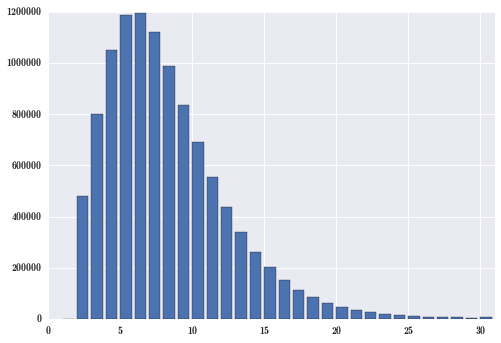

In [27]:
dp_hist = vds.query_genotypes('gs.map(g => g.dp).hist(0, 30, 30)')
plt.xlim(0, 31)
plt.bar(dp_hist.binEdges[1:], dp_hist.binFrequencies)
plt.show()

In [28]:
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int
 }


In [29]:
vds = vds.sample_qc()

In [30]:
pprint(vds.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int,
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     }
 }


In [31]:
df = vds.samples_table().to_pandas()

In [32]:
df.head()

,s,sa.Population,sa.SuperPopulation,sa.isFemale,sa.PurpleHair,sa.CaffeineConsumption,sa.qc.callRate,sa.qc.nCalled,sa.qc.nNotCalled,sa.qc.nHomRef,...,sa.qc.nTransition,sa.qc.nTransversion,sa.qc.dpMean,sa.qc.dpStDev,sa.qc.gqMean,sa.qc.gqStDev,sa.qc.nNonRef,sa.qc.rTiTv,sa.qc.rHetHomVar,sa.qc.rInsertionDeletion
0,HG00096,GBR,EUR,False,False,6,0.979017,10731,230,6321,...,5233,1190,4.566828,2.343927,22.506570,22.531111,4410,4.397479,1.190760,None
1,HG00097,GBR,EUR,True,True,6,0.993705,10892,69,6152,...,5279,1251,9.440750,3.653101,42.334833,28.494689,4740,4.219824,1.648045,None
2,HG00099,GBR,EUR,True,False,6,0.988687,10837,124,6113,...,5377,1229,8.240004,3.720313,37.523761,28.130359,4724,4.375102,1.510096,None
3,HG00100,GBR,EUR,True,False,6,0.999909,10960,1,6088,...,5400,1238,12.756478,3.912233,52.740967,27.669909,4872,4.361874,1.758777,None
4,HG00101,GBR,EUR,False,True,8,0.995347,10910,51,6229,...,5358,1212,6.573118,2.887462,30.568286,25.611360,4681,4.420792,1.478031,None


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1289: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


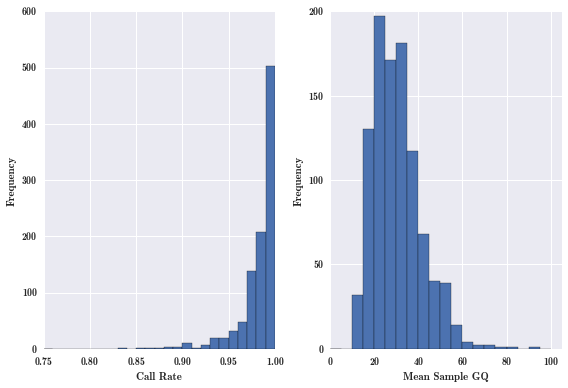

In [33]:
plt.clf()
plt.subplot(1, 2, 1)
plt.hist(df["sa.qc.callRate"], bins=np.arange(.75, 1.01, .01))
plt.xlabel("Call Rate")
plt.ylabel("Frequency")
plt.xlim(.75, 1)

plt.subplot(1, 2, 2)
plt.hist(df["sa.qc.gqMean"], bins = np.arange(0, 105, 5))
plt.xlabel("Mean Sample GQ")
plt.ylabel("Frequency")
plt.xlim(0, 105)

plt.tight_layout()
plt.show()

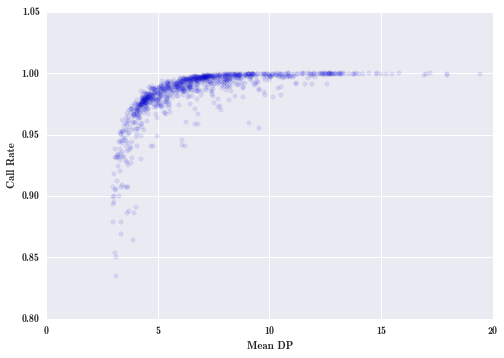

In [34]:
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.show()

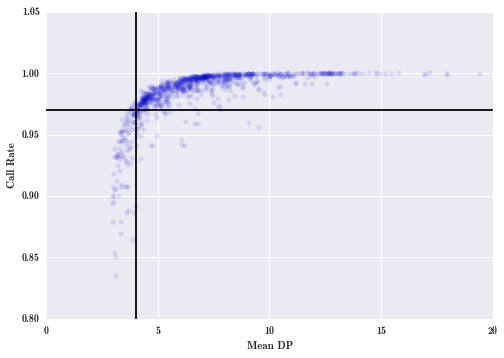

In [35]:
plt.scatter(df["sa.qc.dpMean"], df["sa.qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.axhline(0.97, c='k')
plt.axvline(4, c='k')
plt.show()

In [36]:
vds = vds.filter_samples_expr('sa.qc.dpMean >= 4 && sa.qc.callRate >= 0.97')
print('After filter, %d/1000 samples remain.' % vds.num_samples)

After filter, 843/1000 samples remain.


In [37]:
filter_condition_ab = '''let ab = g.ad[1] / g.ad.sum() in
                         ((g.isHomRef && ab <= 0.1) ||
                          (g.isHet && ab >= 0.25 && ab <= 0.75) ||
                          (g.isHomVar && ab >= 0.9))'''
vds = vds.filter_genotypes(filter_condition_ab)

In [38]:
post_qc_call_rate = vds.query_genotypes('gs.fraction(g => g.isCalled)')
print('post QC call rate is %.3f' % post_qc_call_rate)

post QC call rate is 0.955


In [39]:
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     }
 }


In [40]:
vds = vds.variant_qc().cache()

In [41]:
pprint(vds.variant_schema)

Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHomVar: Double,
         rExpectedHetFrequen

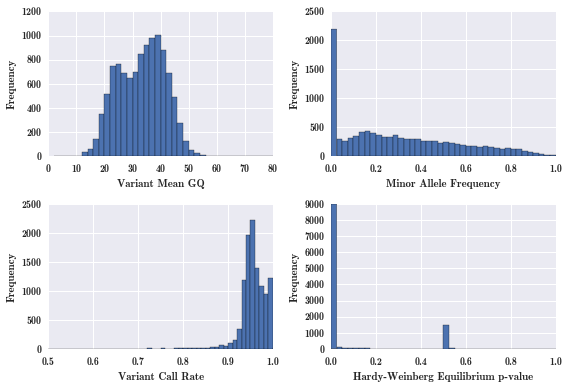

In [42]:
variant_df = vds.variants_table().to_pandas()

plt.clf()
plt.subplot(2, 2, 1)
variantgq_means = variant_df["va.qc.gqMean"]
plt.hist(variantgq_means, bins = np.arange(0, 84, 2))
plt.xlabel("Variant Mean GQ")
plt.ylabel("Frequency")
plt.xlim(0, 80)

plt.subplot(2, 2, 2)
variant_mleaf = variant_df["va.qc.AF"]
plt.hist(variant_mleaf, bins = np.arange(0, 1.05, .025))
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(variant_df['va.qc.callRate'], bins = np.arange(0, 1.05, .01))
plt.xlabel("Variant Call Rate")
plt.ylabel("Frequency")
plt.xlim(.5, 1)

plt.subplot(2, 2, 4)
plt.hist(variant_df['va.qc.pHWE'], bins = np.arange(0, 1.05, .025))
plt.xlabel("Hardy-Weinberg Equilibrium p-value")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


In [43]:
common_vds = (vds
              .filter_variants_expr('va.qc.AF > 0.01')
              .ld_prune(memory_per_core=256, num_cores=4))

2018-06-18 18:34:57 Hail: INFO: Running LD prune with nSamples=843, nVariants=9085, nPartitions=4, and maxQueueSize=257123.
2018-06-18 18:34:58 Hail: INFO: LD prune step 1 of 3: nVariantsKept=8478, nPartitions=4, time=669.110ms
2018-06-18 18:35:00 Hail: INFO: LD prune step 2 of 3: nVariantsKept=8478, nPartitions=12, time=2.207s
2018-06-18 18:35:00 Hail: INFO: Coerced sorted dataset
2018-06-18 18:35:01 Hail: INFO: LD prune step 3 of 3: nVariantsKept=8478, time=887.942ms


In [44]:
common_vds.count()

(843L, 8555L)

In [45]:
gwas = common_vds.linreg('sa.CaffeineConsumption')
pprint(gwas.variant_schema)

2018-06-18 18:35:02 Hail: INFO: Running linear regression on 843 samples with 1 covariate including intercept...


Struct{
     rsid: String,
     qual: Double,
     filters: Set[String],
     pass: Boolean,
     info: Struct{
         AC: Array[Int],
         AF: Array[Double],
         AN: Int,
         BaseQRankSum: Double,
         ClippingRankSum: Double,
         DP: Int,
         DS: Boolean,
         FS: Double,
         HaplotypeScore: Double,
         InbreedingCoeff: Double,
         MLEAC: Array[Int],
         MLEAF: Array[Double],
         MQ: Double,
         MQ0: Int,
         MQRankSum: Double,
         QD: Double,
         ReadPosRankSum: Double,
         set: String
     },
     qc: Struct{
         callRate: Double,
         AC: Int,
         AF: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rHeterozygosity: Double,
         rHetHomVar: Double,
         rExpectedHetFrequen

In [46]:
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.clf()
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax, yMax)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

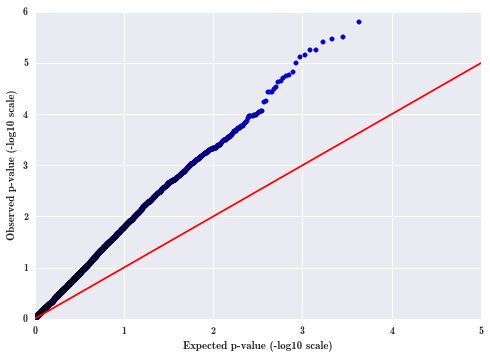

In [47]:
qqplot(gwas.query_variants('variants.map(v => va.linreg.pval).collect()'),
       5, 6)

In [48]:
pca = common_vds.pca('sa.pca', k=5, eigenvalues='global.eigen')

2018-06-18 18:35:05 Hail: INFO: Running PCA with 5 components...


In [49]:
pprint(pca.globals)

{u'eigen': {u'PC1': 56.347079054817996,
            u'PC2': 37.810900301039815,
            u'PC3': 16.919743018222373,
            u'PC4': 2.7073499356343933,
            u'PC5': 2.0851252187821228}}


In [50]:
pprint(pca.sample_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Int,
     qc: Struct{
         callRate: Double,
         nCalled: Int,
         nNotCalled: Int,
         nHomRef: Int,
         nHet: Int,
         nHomVar: Int,
         nSNP: Int,
         nInsertion: Int,
         nDeletion: Int,
         nSingleton: Int,
         nTransition: Int,
         nTransversion: Int,
         dpMean: Double,
         dpStDev: Double,
         gqMean: Double,
         gqStDev: Double,
         nNonRef: Int,
         rTiTv: Double,
         rHetHomVar: Double,
         rInsertionDeletion: Double
     },
     pca: Struct{
         PC1: Double,
         PC2: Double,
         PC3: Double,
         PC4: Double,
         PC5: Double
     }
 }


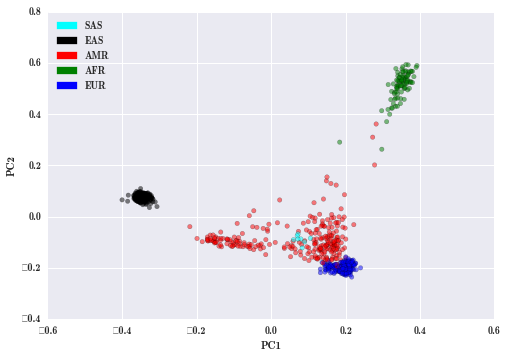

In [51]:
pca_table = pca.samples_table().to_pandas()
colors = {'AFR': 'green', 'AMR': 'red', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan'}
plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"],
            c = pca_table["sa.SuperPopulation"].map(colors),
            alpha = .5)
plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()

In [52]:
pvals = (common_vds
        .annotate_samples_table(pca.samples_table(), expr='sa.pca = table.pca')
        .linreg('sa.CaffeineConsumption', covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.isFemale'])
        .query_variants('variants.map(v => va.linreg.pval).collect()'))

2018-06-18 18:35:20 Hail: INFO: Running linear regression on 843 samples with 5 covariates including intercept...


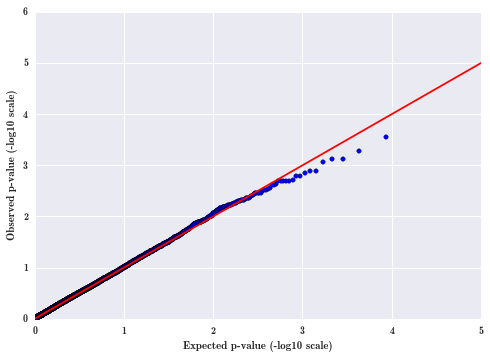

In [53]:
qqplot(pvals, 5, 6)

In [54]:
pvals = (common_vds
        .annotate_samples_table(pca.samples_table(), expr='sa.pca = table.pca')
        .linreg('sa.CaffeineConsumption',
                covariates=['sa.pca.PC1', 'sa.pca.PC2', 'sa.pca.PC3', 'sa.isFemale'],
                use_dosages=True)
        .query_variants('variants.map(v => va.linreg.pval).collect()'))

2018-06-18 18:35:22 Hail: INFO: Running linear regression on 843 samples with 5 covariates including intercept...


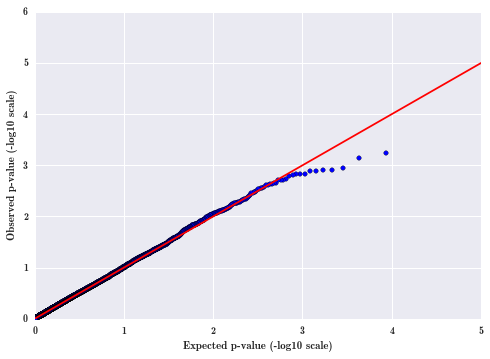

In [55]:
qqplot(pvals, 5, 6)

In [56]:
kt = (vds.genotypes_table()
         .aggregate_by_key(key_expr=['pop = sa.SuperPopulation', 'chromosome = v.contig'],
                           agg_expr=['n_het = g.filter(g => g.isHet()).count()']))

In [57]:
kt.to_dataframe().show()

+---+----------+-----+
|pop|chromosome|n_het|
+---+----------+-----+
|EUR|        14|16380|
|SAS|        17|  511|
|EUR|         5|30717|
|AFR|         7|11889|
|EAS|         9|23951|
|AFR|        21| 3529|
|EAS|         X| 7403|
|EAS|         1|49375|
|EUR|        19|13483|
|AMR|        15|18935|
|AMR|         7|31527|
|EUR|        13|17321|
|EUR|        12|26134|
|EUR|        15|15807|
|EUR|         6|33910|
|EAS|        20|17466|
|SAS|        11|  901|
|AFR|         3|15829|
|EAS|         2|45384|
|AMR|        18|18982|
+---+----------+-----+
only showing top 20 rows



In [58]:
kt2 = (vds.genotypes_table()
          .aggregate_by_key(key_expr=['''maf_bin = if (va.qc.AF < 0.01) "< 1%"
                                                   else if (va.qc.AF < 0.05) "1%-5%"
                                                   else "> 5%" ''',
                                     'purple_hair = sa.PurpleHair'],
                           agg_expr=['mean_gq = g.map(g => g.gq).stats().mean',
                                     'mean_dp = g.map(g => g.dp).stats().mean']))

In [59]:
kt2.to_dataframe().show()

+-------+-----------+------------------+-----------------+
|maf_bin|purple_hair|           mean_gq|          mean_dp|
+-------+-----------+------------------+-----------------+
|   > 5%|       true| 36.09305651197578|7.407450459057423|
|   < 1%|       true| 22.68197887434976|7.374254453728496|
|   < 1%|      false|22.986128698357074|7.492131714314245|
|   > 5%|      false|36.341259980753755|7.533399982371768|
|  1%-5%|       true|24.093123033233528|7.269552536649012|
|  1%-5%|      false|  24.3519587208908|7.405582424428774|
+-------+-----------+------------------+-----------------+

